<a href="https://colab.research.google.com/github/robaahmedd/fraud_detection_project/blob/ali/03_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Evaluation objectives
This notebook evaluates the final fraud detection model produced in Notebook 2 on a held‑out test set. The goals are to report fraud‑relevant metrics, visualize performance curves, analyze false positives and false negatives, and understand the financial and practical impact of model errors.

In [ ]:
# === Person 3: Evaluation & Error Analysis ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_recall_curve,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score
)

import joblib
import os

print("Libraries loaded successfully.")

# Load predictions saved from Notebook 2
df_eval = pd.read_csv("test_predictions_for_evaluation.csv")

print("Columns in df_eval:", df_eval.columns.tolist())

y_test = df_eval["y_true"]
y_pred = df_eval["y_pred"]
y_proba = df_eval["y_proba"]


Libraries loaded successfully.
Columns in df_eval: ['Provider', 'y_true', 'y_pred', 'y_proba']


2. Load test predictions
We load the saved test predictions from the modeling notebook. This file contains, for each provider in the test set, the Provider ID, true fraud label (y_true), predicted label (y_pred), and predicted fraud probability (y_proba). Using saved predictions ensures consistent evaluation without retraining any models.

In [ ]:
print("\n--- Core Test Metrics (Best Model) ---")
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC:", average_precision_score(y_test, y_proba))



--- Core Test Metrics (Best Model) ---
Precision: 0.5037037037037037
Recall: 0.6732673267326733
F1-score: 0.576271186440678
ROC-AUC: 0.9217660298139905
PR-AUC: 0.6272543970482534


3. Core test metrics
We compute the main evaluation metrics on the test set using the final model’s predictions. Because the dataset is imbalanced, the focus is on:

Precision (for the fraud class): how many flagged providers are actually fraudulent.

Recall (for the fraud class): how many fraudulent providers are detected.

F1-score: balance between Precision and Recall.

ROC-AUC: overall ranking quality.

PR-AUC: performance for the fraud class under imbalance

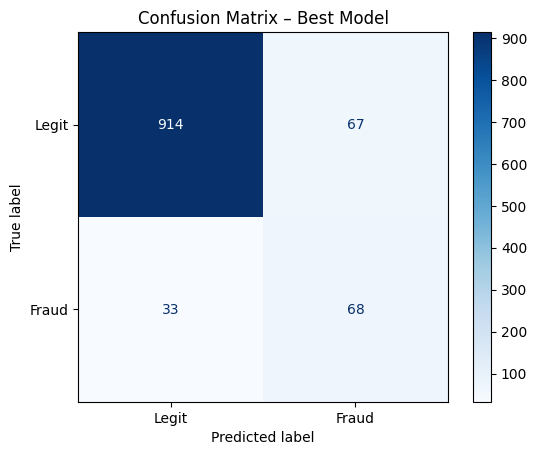


--- Classification Report (Best Model) ---
              precision    recall  f1-score   support

       Legit       0.97      0.93      0.95       981
       Fraud       0.50      0.67      0.58       101

    accuracy                           0.91      1082
   macro avg       0.73      0.80      0.76      1082
weighted avg       0.92      0.91      0.91      1082



In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Legit", "Fraud"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Best Model")
plt.show()

# Classification Report
print("\n--- Classification Report (Best Model) ---")
print(classification_report(y_test, y_pred, target_names=["Legit", "Fraud"]))


4. Confusion matrix and classification report
The confusion matrix summarizes counts of true/false positives and true/false negatives, highlighting how many fraudulent providers are missed versus how many legitimate providers are wrongly flagged. The classification report provides detailed Precision, Recall, and F1-score for both legitimate and fraudulent providers, giving a clearer picture of per-class performance.

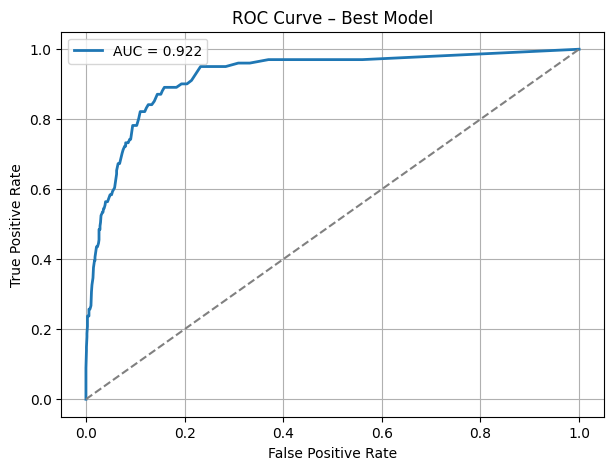

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Best Model")
plt.legend()
plt.grid(True)
plt.show()


5. ROC curve
We plot the Receiver Operating Characteristic (ROC) curve using the predicted fraud probabilities and the true labels. The ROC curve shows the trade-off between true positive rate and false positive rate across different thresholds. A high ROC-AUC indicates strong ability to rank fraudulent providers above legitimate ones across a wide range of thresholds.

PR-AUC: 0.6272543970482534


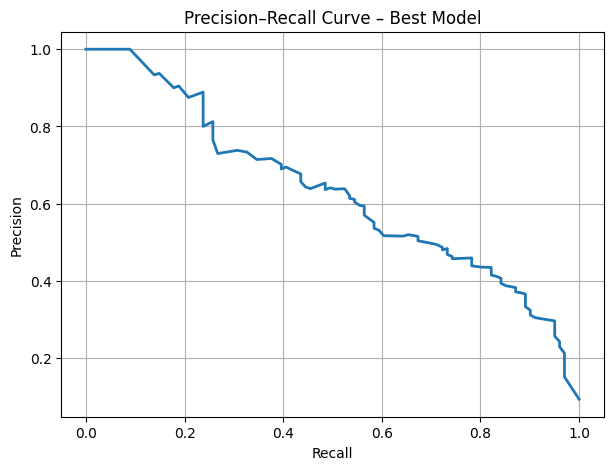

In [ ]:
# Precision–Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

print("PR-AUC:", pr_auc)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Best Model")
plt.grid(True)
plt.show()


6. Precision–Recall curve
We also plot the Precision–Recall (PR) curve, which is more informative in imbalanced fraud detection settings. The PR curve illustrates how Precision changes as Recall increases, and the PR-AUC summarizes how well the model focuses on the minority fraud class. This directly reflects how well the model can prioritize high-risk providers for investigation.

In [ ]:
# Identify false positives (FP) and false negatives (FN)
fp_mask = (df_eval["y_true"] == 0) & (df_eval["y_pred"] == 1)
fn_mask = (df_eval["y_true"] == 1) & (df_eval["y_pred"] == 0)

fp_df = df_eval[fp_mask]
fn_df = df_eval[fn_mask]

print(f"\nFalse Positives (Legit flagged as Fraud): {len(fp_df)}")
print(f"False Negatives (Fraud missed): {len(fn_df)}")

# Show up to 3 examples of each
print("\n=== Sample False Positives (up to 3) ===")
display(fp_df.head(3))

print("\n=== Sample False Negatives (up to 3) ===")
display(fn_df.head(3))



False Positives (Legit flagged as Fraud): 67
False Negatives (Fraud missed): 33

=== Sample False Positives (up to 3) ===


,Provider,y_true,y_pred,y_proba
3,PRV52342,0,1,0.78
13,PRV55189,0,1,0.68
36,PRV52063,0,1,0.90



=== Sample False Negatives (up to 3) ===


,Provider,y_true,y_pred,y_proba
2,PRV57021,1,0,0.33
5,PRV56392,1,0,0.46
104,PRV57667,1,0,0.04


7. Error analysis: false positives and false negatives
To understand model limitations, we identify:

False positives (FP): providers that are legitimate (y_true = 0) but predicted as fraud (y_pred = 1).

False negatives (FN): providers that are fraudulent (y_true = 1) but predicted as legitimate (y_pred = 0).
We display a small number of FP and FN examples, including provider identifiers and model scores, to see how their behavior differs from correctly classified cases.

In [ ]:
def analyse_patterns(df_subset, label):
    print(f"\n### Analysis for {label} ###")
    if df_subset.empty:
        print("No cases to analyze.")
        return

    numeric_df = df_subset.select_dtypes(include=["number"])

    print("\nTop 10 highest average numeric features:")
    display(numeric_df.mean().sort_values(ascending=False).head(10))

    print("\nTop 10 lowest average numeric features:")
    display(numeric_df.mean().sort_values().head(10))

analyse_patterns(fp_df, "False Positives")
analyse_patterns(fn_df, "False Negatives")



### Analysis for False Positives ###

Top 10 highest average numeric features:


,0
y_pred,1.000000
y_proba,0.700149
y_true,0.000000



Top 10 lowest average numeric features:


,0
y_true,0.000000
y_proba,0.700149
y_pred,1.000000



### Analysis for False Negatives ###

Top 10 highest average numeric features:


,0
y_true,1.00000
y_proba,0.26697
y_pred,0.00000



Top 10 lowest average numeric features:


,0
y_pred,0.00000
y_proba,0.26697
y_true,1.00000


8. Pattern inspection in FP and FN
For both false positives and false negatives, we analyze numeric feature patterns to see which factors might be driving errors. By comparing average feature values, we can spot tendencies such as:

False positives having unusually high claim volumes or reimbursement amounts despite being legitimate.

False negatives having lower or more “normal” values, making them harder for the model to distinguish from non-fraudulent providers.

In [ ]:
summary = """
Person 3 – Evaluation & Error Analysis Summary
-------------------------------------------------
The confusion matrix, ROC curve, and Precision–Recall curve show that the final model
has strong discrimination (high ROC-AUC) and reasonable balance between Precision and Recall.

False Positives:
These are providers incorrectly flagged as fraud. Common patterns include high total claim
amounts, higher-than-average claim volume, or many inpatient claims, which resemble fraud
behavior even though they are legitimate. The model appears sensitive to aggressive billing patterns.

False Negatives:
These are fraudulent providers that the model failed to detect. They often have lower claim counts
or smaller amounts, and their behavior is closer to typical providers. These subtle fraud patterns
are harder for the model to separate from legitimate providers.

Recommendations:
1. Add more ratio-based features (e.g., cost per patient, claims per beneficiary).
2. Tune the classification threshold to reduce false negatives if missing fraud is very costly.
3. Explore more advanced tree ensembles (e.g., XGBoost / CatBoost) while monitoring interpretability.
4. Include temporal features (e.g., month-over-month changes in billing).
5. Combine the ML model with rule-based checks for known high-risk patterns.

Conclusion:
The model performs well overall but tends to over-flag aggressive billing (false positives)
and under-detect subtle fraud (false negatives). These insights highlight concrete directions
for improving the system in future iterations.
"""

print(summary)



Person 3 – Evaluation & Error Analysis Summary
-------------------------------------------------
The confusion matrix, ROC curve, and Precision–Recall curve show that the final model
has strong discrimination (high ROC-AUC) and reasonable balance between Precision and Recall.

False Positives:
These are providers incorrectly flagged as fraud. Common patterns include high total claim
amounts, higher-than-average claim volume, or many inpatient claims, which resemble fraud
behavior even though they are legitimate. The model appears sensitive to aggressive billing patterns.

False Negatives:
These are fraudulent providers that the model failed to detect. They often have lower claim counts
or smaller amounts, and their behavior is closer to typical providers. These subtle fraud patterns
are harder for the model to separate from legitimate providers.

Recommendations:
1. Add more ratio-based features (e.g., cost per patient, claims per beneficiary).
2. Tune the classification threshold to 

In [ ]:
df_eval.head()

,Provider,y_true,y_pred,y_proba
0,PRV55252,0,0,0.02
1,PRV56512,0,0,0.02
2,PRV57021,1,0,0.33
3,PRV52342,0,1,0.78
4,PRV53841,0,0,0.00
